In [1]:
import os
from util import *
from logistic_np import *
from keras.models import Model, Sequential, load_model
from keras.layers import Dense,InputLayer, LeakyReLU, BatchNormalization, Input
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from matplotlib import pyplot as plt
from keras.utils import plot_model
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [2]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# Preprocess data
X_train, X_test = normalize_all_pixel(X_train, X_test)
X_train = reshape2D(X_train)
X_test = reshape2D(X_test)

In [4]:
# Define encoder and decoder dimensions
encoder_dim = X_train.shape[1] // 2

In [5]:
# Define Encoder model
Encoder = Sequential([
    InputLayer(input_shape=X_train.shape[1:]),
    Dense(encoder_dim),
    BatchNormalization(),
    LeakyReLU(),
    Dense(encoder_dim),
    Dense(encoder_dim//2)
], name="Encoder")
Encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 392)               307720    
                                                                 
 batch_normalization (BatchN  (None, 392)              1568      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 392)               0         
                                                                 
 dense_1 (Dense)             (None, 392)               154056    
                                                                 
 dense_2 (Dense)             (None, 196)               77028     
                                                                 
Total params: 540,372
Trainable params: 539,588
Non-trainable params: 784
___________________________________________________

In [6]:
# Define Decoder model
Decoder = Sequential([
    InputLayer(input_shape=(encoder_dim//2,)),
    Dense(encoder_dim),
    BatchNormalization(),
    LeakyReLU(),
    Dense(encoder_dim),
    Dense(X_train.shape[1])
], name="Decoder")
Decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 392)               77224     
                                                                 
 batch_normalization_1 (Batc  (None, 392)              1568      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 392)               0         
                                                                 
 dense_4 (Dense)             (None, 392)               154056    
                                                                 
 dense_5 (Dense)             (None, 784)               308112    
                                                                 
Total params: 540,960
Trainable params: 540,176
Non-trainable params: 784
___________________________________________________

In [7]:
# Combine Encoder and Decoder to form Autoencoder model
inp = Input(X_train.shape[1:])
Encoderoutput = Encoder(inp)
Decoderoutput = Decoder(Encoderoutput)
AutoEncodermodel = Model(inputs=inp, outputs=Decoderoutput)
AutoEncodermodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 Encoder (Sequential)        (None, 196)               540372    
                                                                 
 Decoder (Sequential)        (None, 784)               540960    
                                                                 
Total params: 1,081,332
Trainable params: 1,079,764
Non-trainable params: 1,568
_________________________________________________________________


In [8]:
# Compile Autoencoder model
AutoEncodermodel.compile(optimizer="adam", loss="mse")

In [9]:
# Train Autoencoder model
callback = EarlyStopping(monitor='val_loss', patience=3)
hist = AutoEncodermodel.fit(X_train, X_train, epochs=100, validation_data=(X_test, X_test), callbacks=[callback])


Epoch 1/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1611 - val_loss: 0.1002
Epoch 2/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0852 - val_loss: 0.0762
Epoch 3/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0700 - val_loss: 0.0685
Epoch 4/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0646 - val_loss: 0.0697
Epoch 5/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0623 - val_loss: 0.0669
Epoch 6/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0610 - val_loss: 0.0624
Epoch 7/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0601 - val_loss: 0.0630
Epoch 8/100
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0592 - val_loss: 0.0607
Epoch 9/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0585 - val_loss: 0.0612
Epoch 10/100
1875/1875 [==============================] - 13s 7m

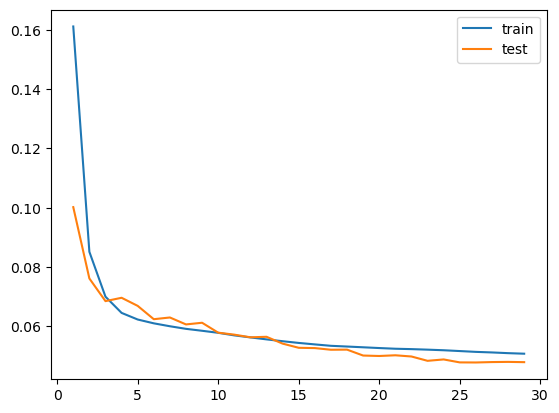

In [10]:
# Plot loss curves
plt.plot(range(1, len(hist.history['loss']) + 1), hist.history['loss'], label="train")
plt.plot(range(1, len(hist.history['loss']) + 1), hist.history['val_loss'], label="test")
plt.legend()
plt.show()

In [11]:
# Save Encoder model
encoder = Model(inputs=inp, outputs=Encoderoutput)
encoder.compile()
if os.path.exists('encoder_v1.keras'):
    os.remove('encoder_v1.keras')  # Deletes the existing file
encoder.save('encoder_v1.keras')

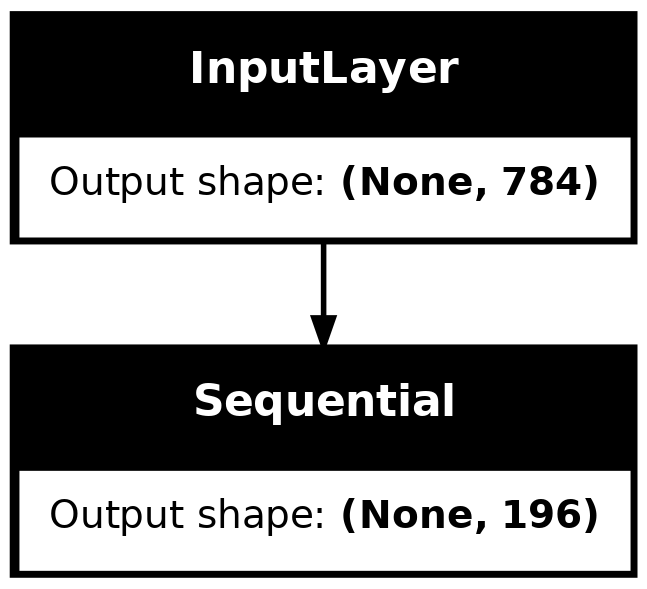

In [24]:

# Visualize Encoder model architecture
plot_model(encoder, 'encoder_compress_v1.png', show_shapes=True)

In [12]:
# Feature extraction using Encoder
feature_extract = load_model('encoder_v1.keras')
X_train_encoded = feature_extract.predict(X_train)
X_test_encoded = feature_extract.predict(X_test)

313/313 [==============================] - 0s 1ms/step


In [13]:
gaussian = GaussianNB()
for i in range(100):
    gaussian.fit(X_train, y_train)
    print("Epoch: ",i )

y_pred = gaussian.predict(X_test)

print("Accuracy: %.2f%%" %(100*accuracy_score(y_test, y_pred)))

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89
Epoch:  90
Epoch:  9

In [14]:
# Gaussian Naive Bayes classifier
gaussian_v2 = GaussianNB()
for i in range(100):
    gaussian_v2.fit(X_train_encoded, y_train)
    print("Epoch: ", i)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89
Epoch:  90
Epoch:  9

In [15]:
# Evaluate Gaussian Naive Bayes classifier
y_pred_v2 = gaussian_v2.predict(X_test_encoded)
accuracy_v2 = accuracy_score(y_test, y_pred_v2)
print("Accuracy: %.2f%%" % (100 * accuracy_v2))

Accuracy: 59.21%


In [16]:
# Logistic Regression classifier on original data
model = LogisticRegression(multi_class="ovr")
model.fit(X_train, y_train)
yhat = model.predict(X_test)
acc_original = accuracy_score(y_test, yhat)
print(f"Accuracy score (Original data): {acc_original}")

d:\anaconda\envs\py39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy score (Original data): 0.7379


In [17]:
# Logistic Regression classifier on encoded data
model = LogisticRegression(multi_class="ovr")
model.fit(X_train_encoded, y_train)
yhat = model.predict(X_test_encoded)
acc_encoded = accuracy_score(y_test, yhat)
print(f"Accuracy score (Encoded data): {acc_encoded}")

d:\anaconda\envs\py39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy score (Encoded data): 0.6404


In [18]:
from sklearn.metrics import precision_score, f1_score

# Calculate Precision and F1 score for Gaussian Naive Bayes
precision_nb = precision_score(y_test, y_pred_v2, average='weighted')
f1_nb = f1_score(y_test, y_pred_v2, average='weighted')

print("Gaussian Naive Bayes:")
print(f"Precision: {precision_nb:.4f}")
print(f"F1 Score: {f1_nb:.4f}")

# Calculate Precision and F1 score for Logistic Regression
precision_lr = precision_score(y_test, yhat, average='weighted')
f1_lr = f1_score(y_test, yhat, average='weighted')

print("\nLogistic Regression:")
print(f"Precision: {precision_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")

Gaussian Naive Bayes:
Precision: 0.5830
F1 Score: 0.5840

Logistic Regression:
Precision: 0.6325
F1 Score: 0.6338


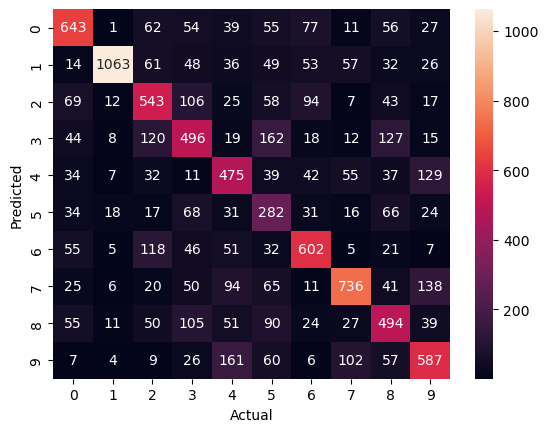

In [19]:
confusion_matrix(y_test, y_pred_v2)
